In [1]:
# view how polyfit make sense with FX data (oanda)

In [1]:
from OANDA_FUNC_CONF import *
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

In [2]:
# accountID = '101-011-15612193-001'
# access_token = '2897d1ae787989d30996a8a9d0a2c03d-7304ab578b56ccb454d311ecbc90cfdb'
# api = API(access_token=access_token, environment="practice")

In [3]:
def get_datas(year=2020,month=1,day=10):
    #fmt = "%Y-%m-%dT%H:%M:00.000000000Z"
    fmt = "%Y-%m-%dT%H:%M:%S.000000000Z"
    _from = datetime(year=year, month=month, day=day, hour=0, minute=0, second=0).strftime(fmt)
    datas = History("S30",5000,_from)
    return datas

def localtime(strf):
    fmt = "%Y-%m-%dT%H:%M:%S.000000000Z"
    ptime = datetime.strptime(strf, fmt)
    
    out = ptime.replace(tzinfo=timezone.utc).astimezone(timezone(timedelta(hours=+7)))
    #out = ptime.replace(tzinfo=timezone.utc).astimezone(tz=None)
    return out

In [60]:
data = get_datas()

In [ ]:
usdjpy = []
jptime = []
first_loop = True
for year in range(2020, 2022):
    print(year)
    for month in range(1,13):
        print(month)
        for day in range (1,31, 2):
            if month == 2:
                if day > 28:
                    continue
            # start code
            datas = get_datas(year=year,month=month,day=day)
            t = list(map(localtime, datas.t))
            if first_loop:
                usdjpy.extend(datas.y)
                jptime.extend(t)
                first_loop = False
            else:
                yy = [ y for y, t in zip(datas.y, list(map(localtime, datas.t))) if t > jptime[-1]]
                tt = [ t for y, t in zip(datas.y, list(map(localtime, datas.t))) if t > jptime[-1]]
                usdjpy.extend(yy)
                jptime.extend(tt)

In [ ]:
# save
with open("2021_usdjpy_s30", "wb") as f:
    pickle.dump((usdjpy, jptime), f)

In [4]:
# read
with open("2021_usdjpy_s30", "rb") as f:
    usdjpy, jptime = pickle.load(f)

In [5]:
def curvefit(arrY):
    y = arrY
    x = np.arange(len(y))
    coe = np.polyfit(x,y,1)
    y1 = np.poly1d(coe)(x)
#     plt.scatter(x,y)
#     plt.plot(x,y1)
#     plt.show()
    
    # 決定関数
    k = np.corrcoef(y,y1)[0,1] **2
#     print("A1:{:.5f} A2:{:.5f} A3{:.5f}".format(coe[0], coe[1], coe[2]))
#     print("Fit rate is {}".format(k))
    return coe, k

def curvefit3(arrY):
    y = arrY
    x = np.arange(len(y))
    coe = np.polyfit(x,y,5)
    y1 = np.poly1d(coe)(x)
#     x2 = np.arange(len(y)*2)
#     y2 = np.poly1d(coe)(x2)
    plt.scatter(x,y)
    plt.plot(x, y1)
#     plt.plot(x2,y2)
    plt.show()
    
    # 決定関数
    k = np.corrcoef(y,y1)[0,1] **2
    print("A1:{:.5f} A2:{:.5f} A3{:.5f}".format(coe[0], coe[1], coe[2]))
    print("Fit rate is {}".format(k))
    return coe, k

def linearFit(arrY):
    y = arrY
    x = np.arange(len(y))
    coe = np.polyfit(x,y,1)
    y1 = np.poly1d(coe)(x)
    #     plt.scatter(x,y)
    #     plt.plot(x,y1)
    #     plt.show()
    # 決定関数
    k = np.corrcoef(y,y1)[0,1] **2
    #     print("A1:{:.5f} A2:{:.5f} A3{:.5f}".format(coe[0], coe[1], coe[2]))
    #     print("Fit rate is {}".format(k))
    return coe, k

In [46]:
W = 1200 # org 1200
W2 = 400
arr = np.array(usdjpy)#[60000:120000] # cut out some data

In [47]:
# 一次関数
fit_rates = np.zeros(len(arr))
trend = np.zeros(len(arr))
fit_rates2 = np.zeros(len(arr))
trend2 = np.zeros(len(arr))
errors = np.zeros(len(arr))
# a2 = np.zeros(len(usdjpy))
i = W
while i < len(arr) - W:
    y = arr[i-W:i]
    coe, k = linearFit(y)
    fit_rates[i-1] = k
    trend[i-1] = coe[0]
    
    est = np.poly1d(coe)(np.arange(len(y)))
    errors[i-1] = (abs(y - est)).mean()
#     ((y - est)**2).mean()
    
#     y2 = arr[i-W2:i]
#     coe2, k2 = linearFit(y2)
#     fit_rates2[i-1] = k2
#     trend2[i-1] = coe2[0]

#     a2[i] = coe[1]
    i += 1
    

In [60]:
# make signal points
signalsU = np.zeros(len(arr))
signalsD = np.zeros(len(arr))
signalsU2 = np.zeros(len(arr))
signalsD2 = np.zeros(len(arr))
sigContinued = np.zeros(len(arr))
i = W
lastSig = 0
sigN = 0
while i < len(arr) - W:
    # fit continue check
    # /fit continue check
    if fit_rates[i] > 0.65:
        if trend[i] > 0:
            signalsU[i] = 1
            currentSig = 1
        if trend[i] < 0:
            signalsD[i] = 1
            currentSig = -1
    else:
        currentSig = 0
    if lastSig != 0:
        if lastSig == currentSig:
            sigN += 1
        else:
            sigN = 0
        
    if fit_rates2[i] > 0.65:
        if trend2[i] > 0:
            signalsU2[i] = 1
        if trend2[i] < 0:
            signalsD2[i] = 1
    i += 1
    lastSig = currentSig
    sigContinued[i] = sigN 
    
signalsU = np.where(signalsU > 0, arr, None)
signalsD = np.where(signalsD > 0, arr, None)
signalsU2 = np.where((signalsU2 > 0) & (signalsU != None), arr, None)
signalsD2 = np.where((signalsD2 > 0) & (signalsD != None), arr, None)

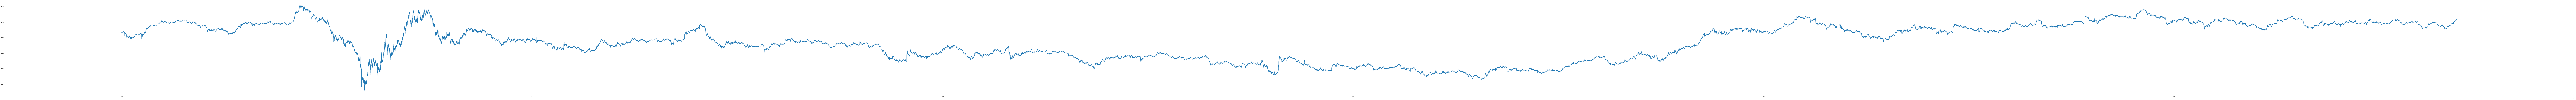

In [61]:
showMulti([arr, signalsU2, signalsD2])

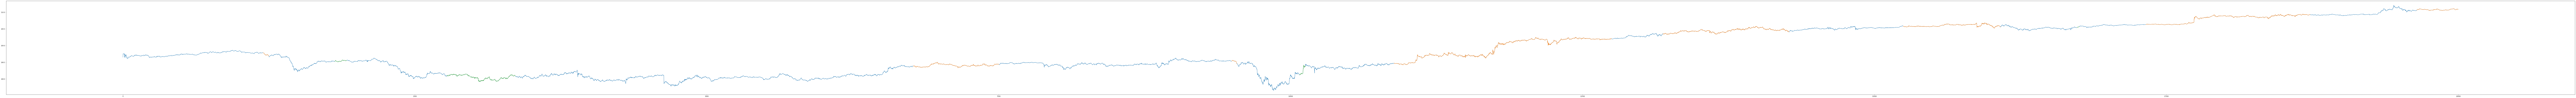

In [11]:
showMulti([arr[:20000], signalsU[:20000], signalsD[:20000]])

In [49]:
arr.shape

(1138349,)

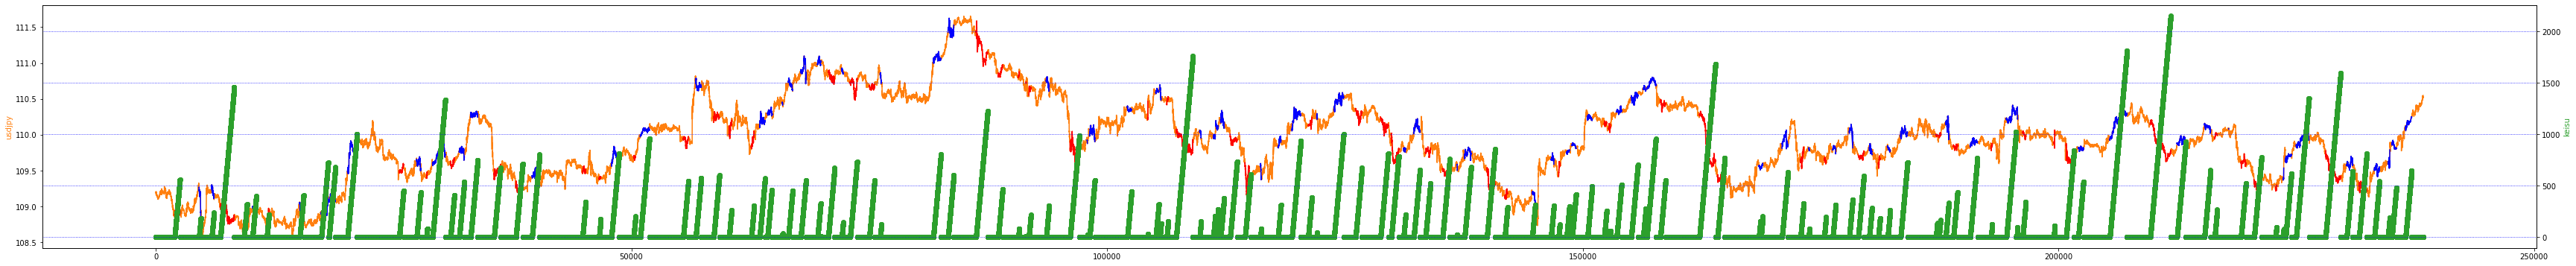

In [62]:
x1, x2 = 900000, 1200000
fig, ax1 = plt.subplots()
#     fig.figure(figsize=(16,6))
fig.set_figheight(6)
fig.set_figwidth(60)
color = 'tab:orange'
ax1.set_ylabel('usdjpy', color=color)
ax1.plot(arr[x1:x2], color=color)
ax1.plot(signalsU[x1:x2], color="blue")
ax1.plot(signalsD[x1:x2], color="red")
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("keisu", color=color)
ax2.scatter(np.arange(len(sigContinued[x1:x2])),sigContinued[x1:x2], color=color)
ax2.grid(axis='y',linestyle='dotted', color='b')

In [ ]:
# sigContinued thres is 1000?
# 5万あkら10万期間

In [10]:
# norm
def norm(arr):
    arr = np.array(arr)
    return ( arr - arr.min() ) / ( arr.max() - arr.min() )
    
# そのまま重ねてマルチ
def showMulti(listY):
    plt.figure(figsize=(320,12))
    for y in listY:
        plt.plot(y)    
    

In [ ]:
trend_backup = trend.copy()

In [ ]:
trend = np.where(fit_rates > 0.87, trend_backup, None)


In [ ]:
# 正規化せずに重ねて表示 

x1, x2 = 0, 10000
for i in range(40):
    fig, ax1 = plt.subplots()
#     fig.figure(figsize=(16,6))
    fig.set_figheight(6)
    fig.set_figwidth(16)
    color = 'tab:orange'
    ax1.set_ylabel('usdjpy', color=color)
    ax1.plot(arr[x1:x2], color=color)
    
    ax2 = ax1.twinx()
    color = "tab:green"
    ax2.set_ylabel("keisu", color=color)
    ax2.scatter(np.arange(len(trend[x1:x2])),trend[x1:x2], color=color)
    ax2.grid(axis='y',linestyle='dotted', color='b')
    
    x1 += 10000
    x2 += 10000

ax1.tick_params(axis='y', labelcolor=color)

In [41]:

class Trade:
    def __init__(self, arr):
        self.position = 0
        self.inPrice = 0
        self.coe = None
        self.timeAfterOrder = 0
        self.arrAtOrder = np.array([])
        self.profit = 0
        self.arr = arr
    def long(self,i, arr, coe):
        if self.position == 0:
            self.inPrice = self.arr[i]
            self.position = 1
            self.arrAtOrder = arr.copy()
            self.coe = coe
            self.timeAfterOrder = 0
        elif self.position == 1:
            pass
        elif self.position == -1:
            self.close(i)
    def short(self, i, arr, coe):
        if self.position == 0:
            self.inPrice = self.arr[i]
            self.position = -1
            self.arrAtOrder = arr.copy()
            self.coe = coe
            self.timeAfterOrder = 0
        elif self.position == 1:
            self.close(i)
        elif self.position == -1:
            pass  
    def close(self,i):
        if self.position > 0:
            profit = self.arr[i] - self.inPrice
        elif self.position < 0:
            profit = self.inPrice - self.arr[i]
        else:
            profit = None
        if profit != None:
            print("profit: ", profit)
        else:
            print("WARNING >>>>> DID NOT HAVE ANY POSITION BUT CLOSING...")
        self.profit += profit
        self.position = 0  
        self.timeAfterOrder = 0
        print("total profit: ", self.profit)


    def lossCut(self,W, currentPrice):
        estimatedPrice = np.poly1d(self.coe)(self.timeAfterOrder + W + 1)
        # caluclate acceptable error
        est = np.poly1d(self.coe)(np.arange(len(self.arrAtOrder)))
        error = abs(self.arrAtOrder - est).mean() 
        # error =0
        self.timeAfterOrder += 1
        if self.timeAfterOrder > 20:
            if self.position == 1:
                r = estimatedPrice - error > currentPrice
                print(r, "est {} now {}".format(estimatedPrice, currentPrice))
                return r 
            elif self.position == -1:
                r = estimatedPrice + error < currentPrice
                print(r, "est {} now {}".format(estimatedPrice, currentPrice))
                return r  






In [ ]:
# Policy Run
        
t = Trade(usdjpy)
i = W
position = 0
profit = 0
trigger = 0 # 連続出現検知
lastA = 0 # 前回の傾き
while i < len(usdjpy):
    y = usdjpy[i-W:i]
    coe, k = linearFit(y)
    
    # control k thres
    if t.position != 0: # out
        k_thres = 0.7
    else: # in
        k_thres = 0.7
    # /contorl k thres
    
    # check A change 
    currentA = 1 if coe[0] > 0 else -1
    
    # has postion 
    # if t.position ==1:
    #     if t.lossCut(W,usdjpy[i]):
    #         t.close(i)
    #     # i += 1
    #     # continue
    # elif t.position == -1:
    #     if t.lossCut(W,usdjpy[i]):
    #         t.close(i)
    #     # i += 1
    #     # continue
    
    
    # for order
    if k > k_thres:
        if currentA != lastA:
        # process for trigger and order
            if trigger == 0: # まだ初回シグナル無し
                trigger = currentA
            elif trigger != 0: # 初回シグナル有り
                if trigger ==1 and currentA ==1:
                    t.long(i,y,coe)
                    print("**********************long")
                    trigger = 0
                elif trigger == -1 and currentA == -1:
                    t.short(i,y,coe)
                    print("**********************short")
                    trigger = 0
        lastA = currentA 
# old
#     if coe[0] > 0 and k > k_thres:
#         if t.position == 0:
#             print("**********************")
#             print("Long Condtion: {:.5f}, {:.5f}".format(coe[0], k))
#             print("Time:{}".format(jptime[i]))
#         t.long(i)
        
#     elif coe[0] < 0 and k > k_thres:
#         if t.position == 0:
#             print("**********************")
#             print("Short Condtion: {:.5f}, {:.5f}".format(coe[0], k))
#             print("Time:{}".format(jptime[i]))
#         t.short(i)
# /old
        
    i += 1
    
print("************\n*************END")     

In [ ]:
# 正規化して重ねて表示

x1, x2 = 0, 10000
for i in range(40):
    plt.figure(figsize=(16,6))
    plt.plot(norm(usdjpy[x1:x2]))
    plt.plot(norm(trend[x1:x2]), "orange")
    plt.plot(norm(a2[x1:x2]), "green")
#     plt.plot(np.zeros(len(usdjpy[x1:x2]))+ 0.2)
#     plt.plot(np.zeros(len(usdjpy[x1:x2]))+ 0.8)
    
#     plt.plot(norm(fit_rates[x1:x2]), "green")
    
    x1 += 10000
    x2 += 10000

In [ ]:
min(trend[5000:10000]) # 0.000017

In [ ]:
plt.plot(usdjpy[W+5000:10000+W])

In [ ]:

i = W
pause = False
result= []
policy = {}


trend = None
def trendChanged(trend, c):
    if trend == None:
        if c > 0:
            trend = 1
        elif c < 0:
            trend = -1
        return 0
    else:
        if c > 0:
            trendnew = 1
        elif c < 0:
            trendnew = -1
            
        if trend != trendnew:
            trend = trendnew
            return trendnew
        else:
            return 0



while i < len(arr):
    y = arr[i-W:i]
    coe, k = curvefit(y)

    i += 1

    
    if pause:
#         input()
        pause = False
    if coe[0] < -0.000013: # 
        
#         input()

        result.append( arr[i+20] - arr[i] - 0.006)
#         result.append(  arr[i] - arr[i+W] - 0.006)
        print("profit now : ", sum(result))
        pause = True
        i += (W - 1)
    
#     elif k > 0.8 and coe[0] > 0 and coe[1] < 0:
#         result.append( arr[i] - arr[i+W] - 0.006)
#         print("profit now : ", sum(result))
#         pause = True
#         i += (W - 1)
#         pass
    

In [ ]:
print(len(result))






























print(sum(result))

In [ ]:
result

In [ ]:
len([v for v in result if v > 0])